In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import os
import matplotlib as mpl
from PIL import Image
from palettable.cmocean.sequential import Deep_20
deep = mcolors.ListedColormap(Deep_20.mpl_colors)
import glob
from matplotlib import colors
from matplotlib.colors import LogNorm
import metpy.calc as calc
from metpy.units import units
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import TwoSlopeNorm
import h5py
from matplotlib.lines import Line2D

/home/cneumaie/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [83]:
style = "/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle"

plt.style.use(style)
from matplotlib import rcParams

###Figure Settings
# -- Fonts --
rcParams['font.size'] = 29


Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 15 ("xtick.color: 'k'")
Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 16 ("ytick.color: 'k'")
Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 27 ('axes.edgecolor:222222')


In [54]:
savePath = "./CPTrain_Figs/"

In [55]:
def calc_cpspeed(cp_edges_n, cp_edges_s):
    '''calculates the avg speed of each cold pool's edge through a centered in time aprrroach'''
    dx = 100
    dt = 300
    cp1_n_speed = []
    cp1_s_speed = []
    cp2_n_speed = []
    cp2_s_speed = []
    diff = 2
    cp_speed_n_temp = dx*(cp_edges_n[2+diff:]-cp_edges_n[2:-diff])/(diff*dt)
    cp_speed_s_temp = -(dx*(cp_edges_s[2+diff:]-cp_edges_s[2:-diff])/(diff*dt))
    times = np.arange(len(cp_speed_n_temp))*5+5
    times = times[1:]
    cp_speed_n_temp[1:,3] = times
    cp_speed_s_temp[1:,3] = times
    
    # cp_speed_s_temp_2 = np.newaxis(np.arange(len(cp_speed_n_temp))*5, axis =2)
    return cp_speed_n_temp, cp_speed_s_temp

In [56]:
def calc_avgcpspeed(cp_speed_n, cp_speed_s, cp2_start, time_avg,time_start, mode):
    '''calculates the avg cp speed over time
       time_avg is the time period to average over in number of indicies
       cp2_start is the index of the CP2 release time + 10 minutes 
       time_start is the first timestep to calculate the time average over
       cp_speed_n and cp_speed_s are the arays calculated in calc_cpspeed'''
    
    cp2_start_speed = cp2_start+time_start
    if mode == "mean":
        cp1_speed_avg_n = np.nanmean(cp_speed_n[time_start:time_start+time_avg,0]) ##this should return one value
        cp1_speed_avg_s = np.nanmean(cp_speed_s[time_start:time_start+time_avg,0])
        cp2_speed_avg_n = np.nanmean(cp_speed_n[cp2_start_speed:cp2_start_speed+time_avg,1]) ##this should return one value
        cp2_speed_avg_s = np.nanmean(cp_speed_s[cp2_start_speed:cp2_start_speed+time_avg,1]) 
    
    return cp1_speed_avg_n, cp1_speed_avg_s, cp2_speed_avg_n, cp2_speed_avg_s

In [57]:
def func4(filePaths, time_avg,time_start, mode = "mean"):
    '''gets cp speeds and puts them into a pandas DataFrame and a Numpy array for each case'''
    temp_list = [5,10,20]
    time_list = [30,60,90, 120]
    wind_list = ['shear', 'u0']
    
    speed_dict_cp1 = {}
    speed_dict_cp2 = {}
    wind_list_pd  = []
    cp1_temp_list = []
    cp2_temp_list = []
    time_list_pd = []
    cp1_speed_list = []
    cp2_speed_list = []

    cp1_same_cp2_speed_list = []
    test_array = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list), 3))   
    for filePath in filePaths:
        outfilename = filePath
        if "30min" in outfilename:
            cp2_start = 8
        elif "60min" in outfilename:
            cp2_start = 14
        elif "90min" in outfilename:
            cp2_start = 20
        elif "120min" in outfilename:
            cp2_start = 26 
       
        cp_edges = xr.open_dataset(filePath)
        
        cp_edges_n = cp_edges["cp_edges_n"]
        cp_edges_s = cp_edges["cp_edges_s"]
        cp_speed_n, cp_speed_s = calc_cpspeed(cp_edges_n, cp_edges_s)
        cp1_avg_speed_n, cp1_avg_speed_s,cp2_avg_speed_n, cp2_avg_speed_s = calc_avgcpspeed(cp_speed_n, cp_speed_s, cp2_start, 
                                                                                            time_avg,time_start,mode)          
        cp_edges.close()
        if "u0" in filePath:
            cp1_avg_speed = np.nanmean([cp1_avg_speed_n, cp1_avg_speed_s])
            cp2_avg_speed = np.nanmean([cp2_avg_speed_n, cp2_avg_speed_s])
        else:
            cp1_avg_speed = cp1_avg_speed_n
            cp2_avg_speed = cp2_avg_speed_n
        for w,wind in enumerate(wind_list):
            for c,CP1_temp in enumerate(temp_list):
                for k,CP2_temp in enumerate(temp_list):
                    for t,time in enumerate(time_list):
                        if f"CP1_{CP1_temp}k_CP2_{CP2_temp}k_{time:03}min_{wind}_v2" in filePath:
                            # if CP1_temp == CP2_temp and time ==60:
                                # print(filePath)
                                # print(f"CP1 south edge: {cp_edges_s[2,0]}")
                                # print(f"CP1 north edge: { cp_edges_n[2,0]}")
                                # print(f"CP2 south edge: {cp_edges_s[cp2_start,1]}")
                                # print(f"CP2 north edge: {cp_edges_n[cp2_start,1]}")
                            test_array[w,c,k,t,0] = np.copy(cp1_avg_speed)
                            test_array[w,c,k,t,1] = np.copy(cp2_avg_speed)
                            wind_list_pd.append(wind)
                            cp1_temp_list.append(CP1_temp)
                            cp2_temp_list.append(CP2_temp)
                            time_list_pd.append(time)
                            cp1_speed_list.append(cp1_avg_speed)
                            cp2_speed_list.append(cp2_avg_speed)
   
    for filePath in filePaths:
        for w,wind in enumerate(wind_list):
            for c,CP1_temp in enumerate(temp_list):
                for k,CP2_temp in enumerate(temp_list):
                    for t,time in enumerate(time_list):
                        if f"CP1_{CP1_temp}k_CP2_{CP2_temp}k_{time:03}min_{wind}_v2" in filePath:
                            test_array[w,c,k,t,2] = np.copy(test_array[w,k,k,-1,0])  ### Setting a new CP1 speed to be the CP1 the same strength as CP2 
                            cp1_same_cp2_speed_list.append(np.copy(test_array[w,k,k,-1,0]))
    columns = ['Wind', 'CP1_Temp', 'CP2_Temp', 'dt(CPs)', 'CP1_speed', 'CP2_speed', 'CP1_eq_CP2_speed']
    data = list(zip(np.array(wind_list_pd), np.array(cp1_temp_list), np.array(cp2_temp_list), np.array(time_list_pd),
            np.array(cp1_speed_list), np.array(cp2_speed_list), np.array(cp1_same_cp2_speed_list)))
    speeds_dataframe = pd.DataFrame(data, columns = columns)
    
    return speeds_dataframe, test_array

In [91]:
def plot_cp2speeds_diffs(data_array,time_avg,time_start,axes,savePath, mode = "NoShear", mode2 = "mean"):
    '''Plots Figure 3a-c (if mode == "NoWind") or 3d-f (if mode =="Shear")
    '''

    if mode =="NOWIND":
        plotted_20k = np.transpose(((data_array[1,:,2,:,1,])-data_array[1,:,2,:,2,])/data_array[1,:,2,:,2,])*100
        # plotted_20k = round(plotted_20k,1)
        cp1_20k = round(data_array[1,2,2,-1,2,],1)
        plotted_10k = np.transpose(((data_array[1,:,1,:,1,])-data_array[1,:,1,:,2,])/data_array[1,:,1,:,2,])*100
        cp1_10k = round(data_array[1,1,1,-1,2,],1)
        plotted_5k = np.transpose(((data_array[1,:,0,:,1,])-data_array[1,:,0,:,2,])/data_array[1,:,0,:,2,])*100
        cp1_5k = round(data_array[1,0,0,-1,2,],1)
        label1 = "a)"
        label2 = "b)"
        label3 = "c)"
        ax1 = axes[0][0]
        ax2 = axes[0][1]
        ax3 = axes[0][2]
        save_prefix = "3a-c"
    elif mode =="SHEAR":
        plotted_20k = np.transpose(((data_array[0,:,2,:,1,])-data_array[0,:,2,:,2,])/data_array[0,:,2,:,2,])*100
        cp1_20k = round(data_array[0,2,2,-1,2,],1)
        plotted_10k = np.transpose(((data_array[0,:,1,:,1,])-data_array[0,:,1,:,2,])/data_array[0,:,1,:,2,])*100
        cp1_10k = round(data_array[0,2,1,-1,2,],1)        
        plotted_5k = np.transpose(((data_array[0,:,0,:,1,])-data_array[0,:,0,:,2,])/data_array[0,:,0,:,2,])*100
        cp1_5k = round(data_array[0,0,0,-1,2,],1)
        label1 = "d)"
        label2 = "e)"
        label3 = "f)"
        ax1 = axes[1][0]
        ax2 = axes[1][1]
        ax3 = axes[1][2]
        save_prefix ="3d-f"

    print(f"time_start {(time_start)*5+10} min,time avg {time_avg*5} min {mode2} {mode}")
    cmap = "RdBu_r"
    norm = TwoSlopeNorm(vmin = -50, vcenter = 0, vmax = 50)
    
    

    c = ax1.imshow(plotted_5k, cmap = cmap, norm = norm)
    ax1.set_yticks(ticks = np.arange(4),labels =[30,60,90,120])
    if mode == "SHEAR":
        ax1.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    else:
        ax1.set_xticks(ticks = np.arange(3),labels = ['']*3)
    df = pd.DataFrame(plotted_5k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array for labels
    plotted_5k_label = df.values
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_5k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if type(plotted_5k_label[j,i]) != str: #Check to make sure value is a number for formatting
                ax1.text(i,j,"{:.1f}".format(plotted_5k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color)
            else:
                ax1.text(i,j,"{:}".format(plotted_5k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color)
    

    ax1.set_ylabel("Time between CPs (min)")
    ax1.set_title(f"CP2 -5K \n CP1={cp1_5k} m/s", fontsize = 31)
    ax1.text(-.06, 1.2, label1, ha='left', va='top', weight = 'bold', size = 31, transform=ax1.transAxes)
    
    df = pd.DataFrame(plotted_10k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_10k_label = df.values

    c = ax2.imshow(plotted_10k, cmap = cmap, norm = norm)
    ax2.set_yticks(ticks = np.arange(4))
    ax2.set_yticklabels(['']*4)
    if mode == "SHEAR":
        ax2.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    else:
        ax2.set_xticks(ticks = np.arange(3),labels = ['']*3)
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_10k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if type(plotted_10k_label[j,i]) != str: #Check to make sure value is a number for formatting
                ax2.text(i,j,"{:.1f}".format(plotted_10k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color)
            else:
                ax2.text(i,j,"{:}".format(plotted_10k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color)
    

    ax2.set_title(f"CP2 -10K  \n CP1={cp1_10k} m/s", fontsize = 31)
    ax2.text(-.06, 1.2, label2, ha='left', va='top', weight = 'bold', size = 31, transform=ax2.transAxes)
    if mode =="SHEAR":
        ax2.set_xlabel("CP1 Temperature (K)", fontsize = 35)
    ax1.text(
    x=-0.5,  # Slightly outside the left axis (negative x-value)
    y=0.5,   # Middle of the y-axis
    s=mode,  # The text content
    rotation=90,  # Rotate the text 90 degrees
    verticalalignment='center',  # Centered vertically
    horizontalalignment='center',  # Centered horizontally
    fontsize=35,  # Set the font size
    weight = "bold",
    transform=ax1.transAxes  # Use axis coordinates for positioning
    )
    # ax2.text(0.4, 1.3,mode,ha='center', va='top', weight = 'bold', size = 38, transform = ax2.transAxes)
    
    df = pd.DataFrame(plotted_20k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_20k_label = df.values
    # plt.subplot(133)

    c = ax3.imshow(plotted_20k, cmap = cmap, norm = norm)
    ax3.set_yticks(ticks = np.arange(4))
    ax3.set_yticklabels(['']*4)
    if mode == "SHEAR":
        ax3.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    else:
        ax3.set_xticks(ticks = np.arange(3),labels = ['']*3)

    for j in range(4):
        for i in range(3):
            if np.abs(plotted_20k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if type(plotted_20k_label[j,i]) != str: #Check to make sure value is a number for formatting
                ax3.text(i,j,"{:.1f}".format(plotted_20k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color)
            else:
                ax3.text(i,j,"{:}".format(plotted_20k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color)
    

    ax3.set_title(f"CP2 -20K \n CP1={cp1_20k} m/s", fontsize = 31)
    ax3.text(-.06, 1.2, label3, ha='left', va='top', weight = 'bold', size = 31, transform=ax3.transAxes)
    

    return c

/tmp/ipykernel_671365/2686875095.py:12: RuntimeWarning: Mean of empty slice
  cp2_speed_avg_n = np.nanmean(cp_speed_n[cp2_start_speed:cp2_start_speed+time_avg,1]) ##this should return one value
/tmp/ipykernel_671365/2686875095.py:13: RuntimeWarning: Mean of empty slice
  cp2_speed_avg_s = np.nanmean(cp_speed_s[cp2_start_speed:cp2_start_speed+time_avg,1])
/tmp/ipykernel_671365/2686875095.py:12: RuntimeWarning: Mean of empty slice
  cp2_speed_avg_n = np.nanmean(cp_speed_n[cp2_start_speed:cp2_start_speed+time_avg,1]) ##this should return one value
/tmp/ipykernel_671365/2686875095.py:13: RuntimeWarning: Mean of empty slice
  cp2_speed_avg_s = np.nanmean(cp_speed_s[cp2_start_speed:cp2_start_speed+time_avg,1])
/tmp/ipykernel_671365/1057391046.py:40: RuntimeWarning: Mean of empty slice
  cp2_avg_speed = np.nanmean([cp2_avg_speed_n, cp2_avg_speed_s])
/tmp/ipykernel_671365/2686875095.py:12: RuntimeWarning: Mean of empty slice
  cp2_speed_avg_n = np.nanmean(cp_speed_n[cp2_start_speed:cp2_start_s

time_start 10 min,time avg 50 min mean NOWIND
time_start 10 min,time avg 50 min mean SHEAR


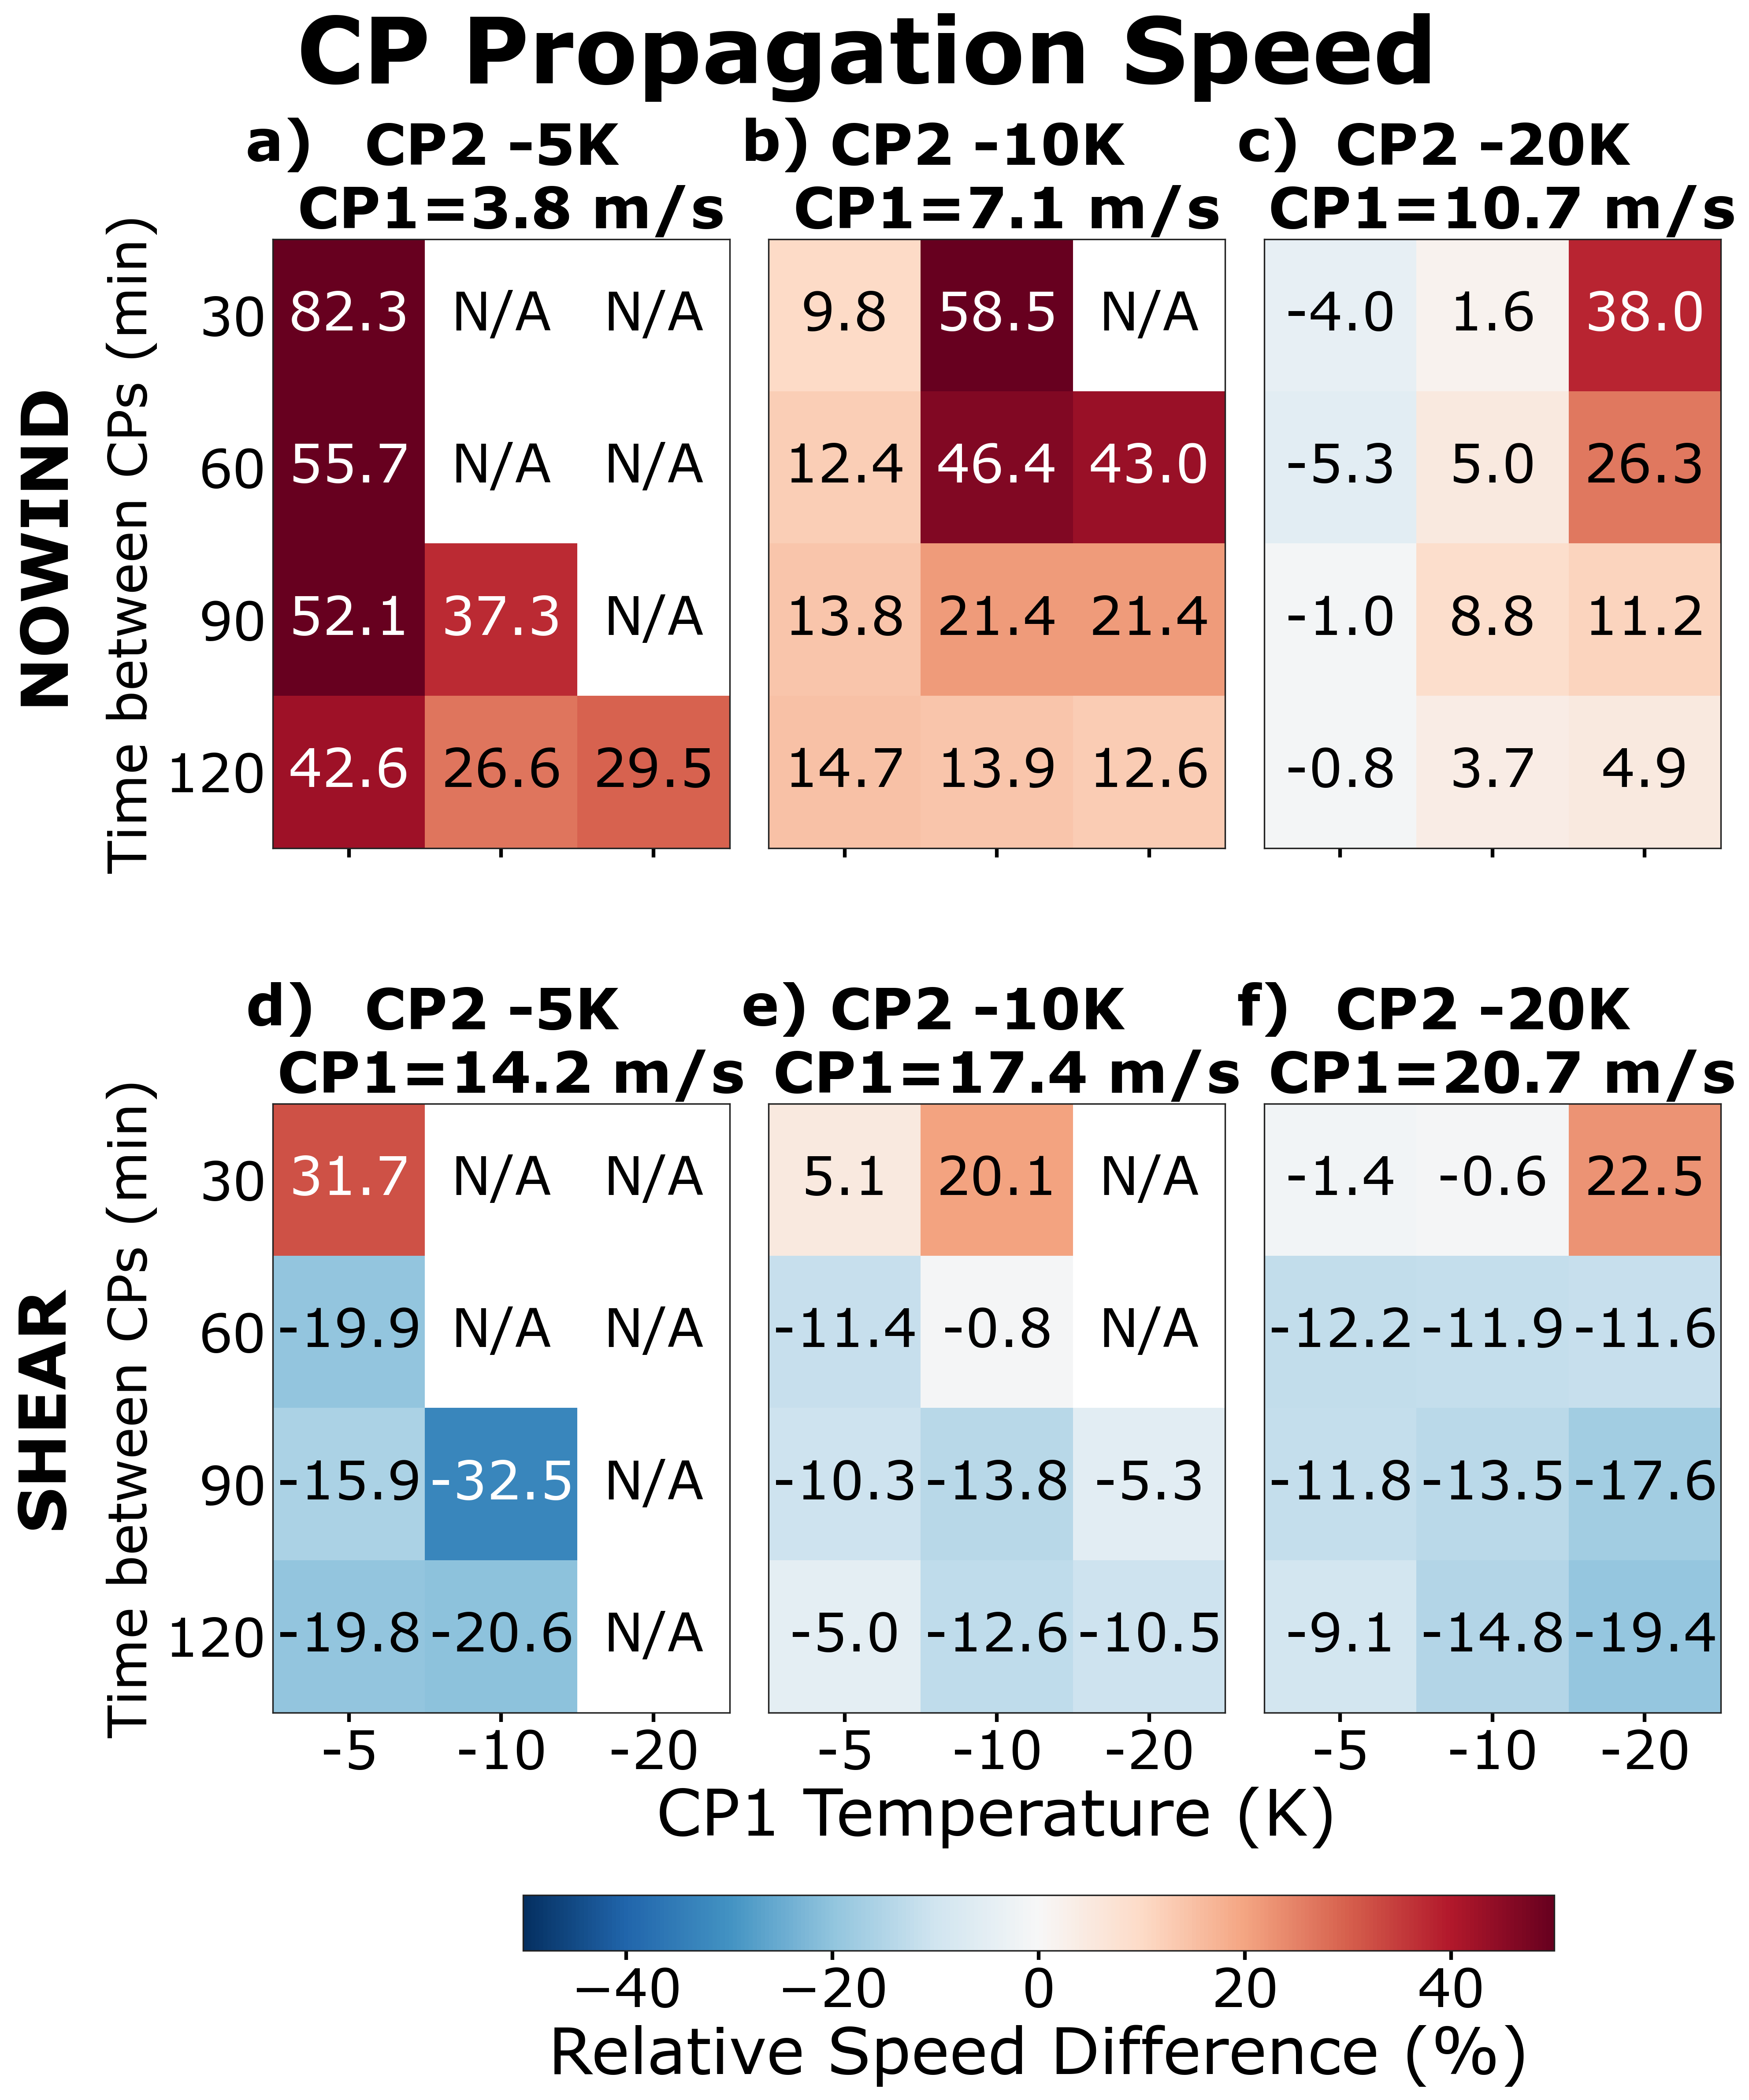

In [93]:
time_avg_list = np.arange(10,11) #averaging over 10 indicies, which is 50 minutes for this simulation
time_start_list = np.arange(0,1) #start averaging at the first available speed timestep
mode_list = ["mean"]
fig, axes= plt.subplots(2,3,figsize = (13,14), constrained_layout = True)
for time_avg in time_avg_list:
    for time_start in time_start_list:
        for mode2 in mode_list:
            filePaths = sorted(glob.glob(f"./cpfile_edges_v7/*.h5"))
            speed_dataframe, test_array = func4(filePaths, time_avg,time_start, mode2)
            c=plot_cp2speeds_diffs(test_array,time_avg,time_start,axes,savePath = savePath, mode = "NOWIND", mode2 = mode2)
            c=plot_cp2speeds_diffs(test_array,time_avg,time_start,axes,savePath = savePath, mode = "SHEAR", mode2 = mode2)
            plt.suptitle("CP Propagation Speed", fontsize = 50, fontweight = "bold", ha = "center")
            cax = fig.add_axes([0.3, -0.05, 0.6, 0.03])
            fig.colorbar(c, pad=0.05, cax = cax, orientation = "horizontal").set_label( label = f"Relative Speed Difference (%)",size = 35)
            plt.savefig(f"{savePath}fig3_speed_v9.png")
            plt.show()
            plt.close()